<a href="https://colab.research.google.com/github/solariasmartinez/Acamica-Data-Science/blob/master/DS_Bit%C3%A1cora_21_CV_y_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validación Cruzada, Curvas de Validación y Curvas de ROC

¡Gracias Martín Gonella por la creación de los contenidos de este encuentro!


En este notebook veremos cómo utilizar Validación Cruzada en Scikit-Learn. Luego, veremos cómo hacer una curva de validación incorporando esta técnica. Finalmente, haremos una curva ROC.


## 1. Validación Cruzada

En esta sección entrenaremos un modelo de árboles de decisión y uno de vecinos más cercanos sobre un nuevo dataset. Luego, evaluaremos estos modelos usando Validación Cruzada. 

### 1.1 Carga de Datos

Scikit-Learn provee varias funciones para cargar datasets y también para generar datasets. Hoy vamos a usar el Breast Cancer Wisconsin (diagnostic) dataset. Empezaremos cargando los datos y haciendo una pequeña exploración.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Si observan la variable `data`, podrán notar que es un `diccionario`, por lo tanto vamos a proceder a convertirlo en un `DataFrame` de Pandas.

In [3]:
df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [4]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


¡Ya tenemos nuestro dataset en un DataFrame de Pandas!

Comencemos con un poco de exploración.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Ahora veamos cuantos datos de cada etiqueta tenemos, para ellos debemos ver la columna `target`.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


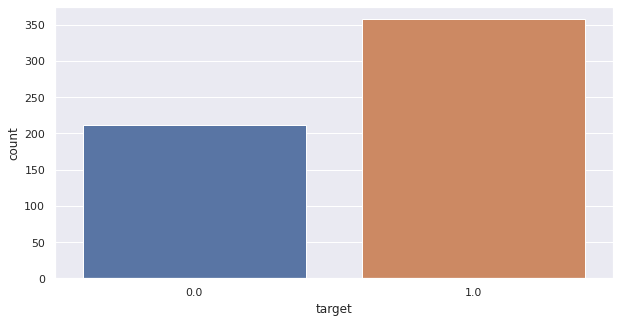

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(df['target'],label="Count")
plt.show()

Para facilitar el análisis, seleccionamos solo aquellas columnas donde los nombres de los atributos comiencen con la palabra `mean`.

In [7]:
features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [8]:
df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


**Ejercicio:** Ahora que ya filtramos las columnas con las cuales vamos a trabajar, crea un `pairplot()` y grafica una matriz de correlaciones. ¿Cuáles atributos están correlacionados?¿Se te ocurre por qué?

### 1.2 Entrenamiento de los modelos

Vamos a entrenar un árbol de decisión de profundidad infinita (`max_depth = None`) y un modelo de vecinos más cercanos con `n_neighbors=1`. Los vamos a entrenar y evaluar haciendo un `train_test_split` (con `test_size=0.10`) de los datos. Pero antes de eso, debemos seleccionar las variables de entrenamiento y la etiqueta.

In [10]:
# X = df.drop(columns = ['target'])
X = df[['mean radius','mean smoothness', 'mean concave points']] #Observa que sólo usamos 3 features del dataset
y = df['target']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

Como ya hemos visto anteriormente, debemos proceder a reescalar los datos.

In [12]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

***Tip:*** Una buena práctica cuando separamos en conjuntos de `train` y `test` es chequear que las distribuciones que obtenemos sean similares. Obviamente, a medida que tenemos más features, esto se hace más difícil.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


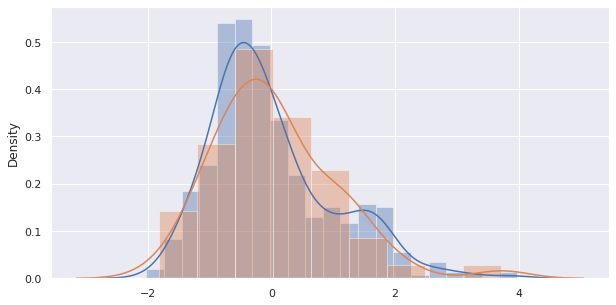

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


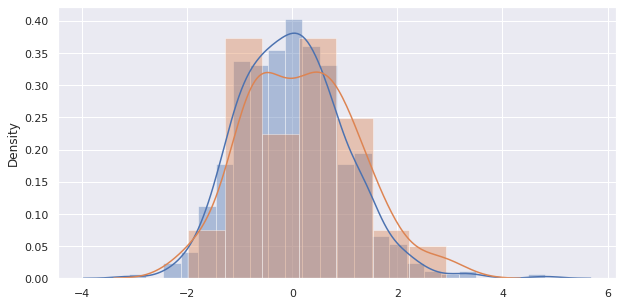

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


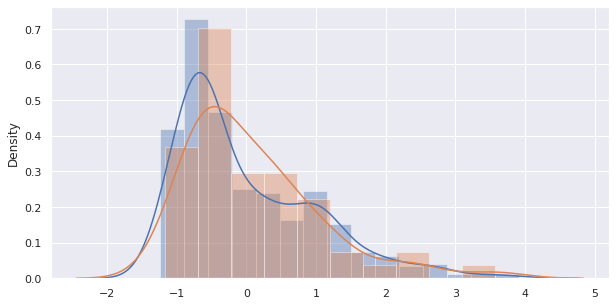

In [13]:
for i in range(X_train.shape[1]):
    plt.figure(figsize=(10,5))
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Pero... ¿Será suficiente chequear esto?

***Tip 2:*** Otras cosa que podemos hacer es chequear que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida.

In [15]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.630859375
Proporcion de etiquetas positiva en los datos de Test:  0.5964912280701754


**Para pensar:** Y si la proporcición no fuera parecida, ¿Qué deberíamos hacer? 

**Ejercicio:** ¿Qué hace el parámetro `stratify` de la función `train_test_split()`?

**Para pensar**: ¿Cuál será desempeño aproximado - accuracy - del modelo más sencillo que podemos crear para detectar casos positivos? Pensar en benchmarks.

#### A entrenar...

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#### `Árbol de Decisión`

In [17]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8771929824561403


#### `KNN`

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [20]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


Bien, cada modelo obtuvo un determinado desempeño... Pero, ¿Este desempeño depende de la partición que hayamos hecho de los datos de `train/test`?

**Ejercicio:** Para ver si esto es cierto, vuelve a realizar la partición de datos pero ésta vez modifiquen el argumento `random_state` de la función `train_test_split()`. ¿Obtienes los mismos resultados?

### 1.3 Validación Cruzada

Vamos a evaluar los modelos que creamos utilizando validación cruzada.

Scikit-Learn tiene varias funciones ya incorporadas que evalúan los modelos usando validación cruzada. Las más sencilla de usar es `cross_val_score()`, que evalúa un score (para clasificaciones por defecto es el `Accuracy`) y de un modelo por CV.

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)

In [25]:
print(tree_scores, knn_scores)
# print(tree_scores.mean(), knn_scores.mean())
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

[0.85087719 0.89473684 0.92982456 0.92982456 0.88495575] [0.8245614  0.86842105 0.85964912 0.92105263 0.87610619]
Accuracy para Tree: 0.90 (+/- 0.06)
Accuracy para KNN: 0.87 (+/- 0.06)


¡Ahora podemos obtener una evaluación del modelo que no depende tanto de la partición hecha!

Por otra parte, `cross_validate()` es otra función muy parecida, pero un poco más versátil e informativa. Además de devolver los `scores`, devuelve algunas métricas que pueden ser útiles, como por ejemplo: tiempo de entrenamiento, los modelos entrenados, etc. Además, permite evaluar más de una métrica.

In [26]:
from sklearn.model_selection import cross_validate

In [27]:
tree_scores = cross_validate(tree, X, y, cv=5)
knn_scores = cross_validate(knn, X, y, cv=5)

In [28]:
print(tree_scores)
print(knn_scores)

{'fit_time': array([0.0044322 , 0.00513983, 0.00225401, 0.00215292, 0.00221276]), 'score_time': array([0.00188684, 0.00098801, 0.00094342, 0.00091219, 0.00093532]), 'test_score': array([0.88596491, 0.88596491, 0.92105263, 0.9122807 , 0.86725664])}
{'fit_time': array([0.00170684, 0.00214267, 0.00208831, 0.00206709, 0.00214195]), 'score_time': array([0.00480676, 0.00524879, 0.00520182, 0.0054419 , 0.00545549]), 'test_score': array([0.8245614 , 0.86842105, 0.85964912, 0.92105263, 0.87610619])}


La siguiente celda imprime una lista de todas las métricas que podemos usar para evaluar con `cross_validate()`

In [29]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

**Ejercicio - Challenge:** Como habrás notado antes de entrenar los modelos, volvímos a filtrar el dataset y sólo usamos tres features del mismo:

```python
X = df[['mean radius','mean smoothness', 'mean concave points']]
```

Vuelve a entrenar los modelos, pero con otras features. Puedes ver la matriz de correlaciones si deseas y en base a lo que ves allí realizar tu elección.

## 2. Curvas de Validación

Ya vimos la importancia de las curvas de validación, ahora veamos como graficar una curva de validación usando los conjuntos de `train` y de `test` que ya creamos y combinando con Validación Cruzada.

In [30]:
scores_train = []
scores_test = []
profundidades = np.arange(1,50)
for max_depth in profundidades:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    scores_train.append(accuracy_score(y_train, y_pred_train))
    scores_test.append(accuracy_score(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

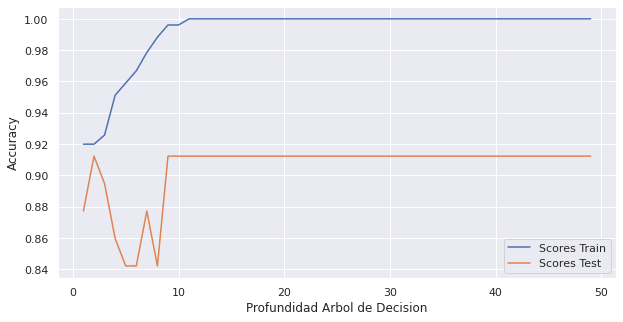

In [31]:
plt.figure(figsize=(10,5))
plt.plot(profundidades,scores_train, label = 'Scores Train')
plt.plot(profundidades,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¡Pero lo ideal sería graficar la curva de validación aplicando validación cruzada!

In [32]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

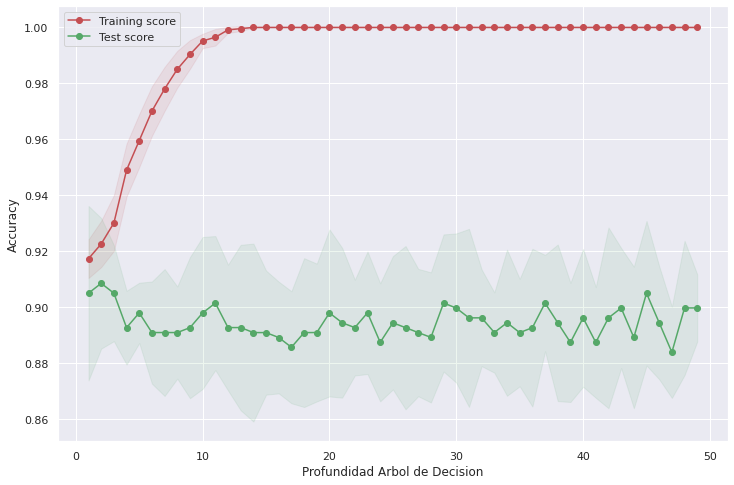

In [33]:
plt.figure(figsize=(12,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

**Ejercicio:** Hacer una curva de validación para un modelo de KNN en función de la cantidad de vecinos, usando además validación cruzada.

## 3. Curva de ROC en Scikit-Learn

En primer lugar, dejamos el link a la Documentación de [Curvas de ROC en Scikit-Learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importamos las librerías necesarias para graficar las curva de ROC y calcular el AUC.

In [35]:
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

In [36]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Binarizamos `y_test`

In [38]:
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
print(y_test[:5])

[[0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


In [39]:
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)
print(y_score[:5])

[[0.2  0.41 0.39]
 [0.4  0.41 0.19]
 [0.2  0.41 0.39]
 [0.2  0.41 0.39]
 [0.2  0.41 0.39]]


Para tener en cuenta:

* `.predict()` dará como salida un 0 o un 1.
* `.predict_proba()` dará como salida una estimación de la probabilidad.

In [40]:
# Computamos los valores de FPR y TPR, para poder luego realizar el gráfico de la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

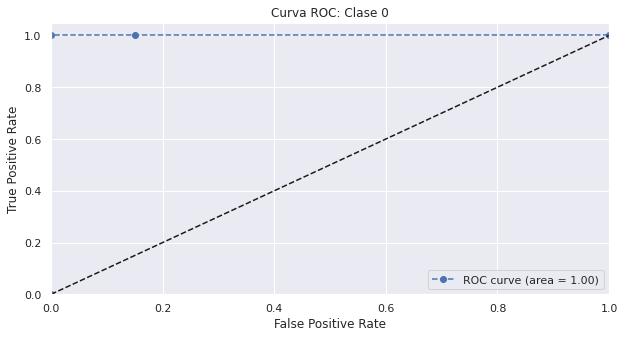

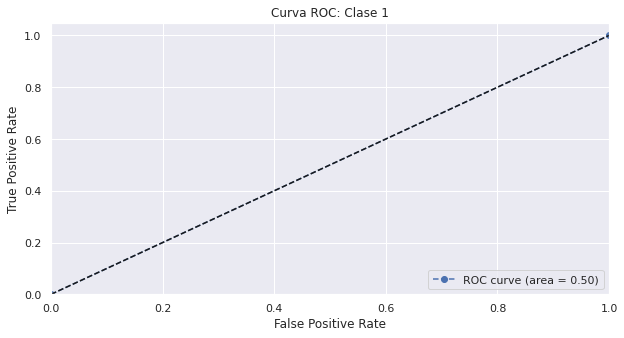

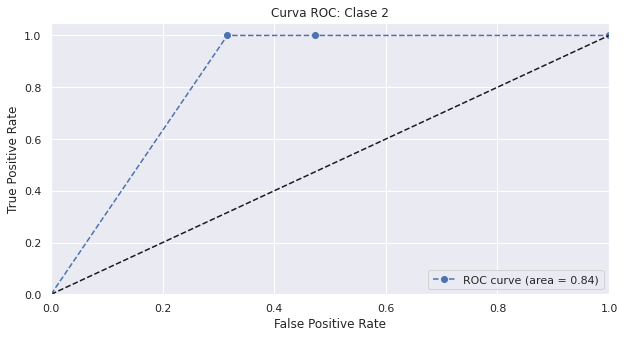

In [41]:
for i in range(n_classes):
    plt.figure(figsize=(10,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.show()

**Ejercicio:** Buscá algún dataset de clasificación binario (por ejemplo: como el de la primera parte de este notebook), entrena un modelo a tu elección y grafica sus curvas de ROC.